In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import boost_histogram as bh
from particle_utils import get_charge_from_pdgc
from tqdm import tqdm

In [17]:
lumi_sf = 3000/40800 # Rescale to 3 fb^-1

In [2]:
light_flav_data = uproot.open("../GeantOutput/40800fb/FASER2_baseline-light2x2-40800fb.gfaser.root:Hits")
charm_flav_data = uproot.open("../GeantOutput/40800fb/FASER2_baseline-charm2x2-40800fb.gfaser.root:Hits")

In [3]:
light_flav_events = light_flav_data.arrays(light_flav_data.keys())
charm_flav_events = charm_flav_data.arrays(charm_flav_data.keys())

In [4]:
def process_one_event(event):
    hits_in_layer = np.zeros(5)
    for x, y, layer, pdgc in zip(event['x'], event['y'], event['layer'], event['pdgc']):
        if -1500 < x < 1500 and -500 < y < 500 and get_charge_from_pdgc(pdgc) != 0:
            hits_in_layer[layer-1] += 1 # layers indexed from 1
    
    return hits_in_layer

In [74]:
def get_hits_in_layers(events):
    # hits_in_layer_inside_dv = np.zeros((0, 5))   # inside decay volume
    # hits_in_layer_outside_dv = np.zeros((0, 5))  # outside decay volume
    
    hits_in_layer_inside_dv = {'NC': np.zeros((0, 5)),  'CC e': np.zeros((0, 5)), 'CC mu': np.zeros((0, 5)), 'CC tau': np.zeros((0, 5))}
    hits_in_layer_outside_dv = {'NC': np.zeros((0, 5)), 'CC e': np.zeros((0, 5)), 'CC mu': np.zeros((0, 5)), 'CC tau': np.zeros((0, 5))}
    
    for event in tqdm(events):
        
        tmp_hits = process_one_event(event)
        vx, vy, vz = event['vertex_x'], event['vertex_y'], event['vertex_z']
        
        is_cc = event['isCC']
        nu_pdgc = event['nu_pdgc']
        
        key = 'NC'
        if is_cc == 1:
            if abs(nu_pdgc) == 12: key = 'CC e'
            elif abs(nu_pdgc) == 14: key = 'CC mu'
            elif abs(nu_pdgc) == 16: key = 'CC tau'
        
        if -1500 < vx < 1500 and -500 < vy < 500 and 0 < vz < 10000:
            hits_in_layer_inside_dv[key] = np.vstack((hits_in_layer_inside_dv[key], tmp_hits))
        else:
            hits_in_layer_outside_dv[key] = np.vstack((hits_in_layer_outside_dv[key], tmp_hits))
    
    return hits_in_layer_inside_dv, hits_in_layer_outside_dv


In [5]:
# def get_hits_in_layers(events):
#     hits_in_layer_inside_dv = np.zeros((0, 5))   # inside decay volume
#     hits_in_layer_outside_dv = np.zeros((0, 5))  # outside decay volume 
#     for event in tqdm(events):
        
#         tmp_hits = process_one_event(event)
#         vx, vy, vz = event['vertex_x'], event['vertex_y'], event['vertex_z']
        
#         if -1500 < vx < 1500 and -500 < vy < 500 and 0 < vz < 10000:
#             hits_in_layer_inside_dv = np.vstack((hits_in_layer_inside_dv, tmp_hits))
#         else:
#             hits_in_layer_outside_dv = np.vstack((hits_in_layer_outside_dv, tmp_hits))
    
#     return hits_in_layer_inside_dv, hits_in_layer_outside_dv

In [75]:
light_flav_hits_in_dv, light_flav_hits_out_dv = get_hits_in_layers(light_flav_events)

  0%|          | 0/68470 [00:00<?, ?it/s]

100%|██████████| 68470/68470 [00:39<00:00, 1745.73it/s]


In [76]:
print(light_flav_hits_in_dv)

{'NC': array([[10.,  4.,  4.,  4.,  2.],
       [ 4.,  1.,  1.,  1.,  1.],
       [ 9.,  4.,  4.,  4.,  4.],
       ...,
       [ 9.,  6.,  6.,  5.,  3.],
       [ 8.,  7.,  7.,  6.,  6.],
       [ 8.,  3.,  3.,  3.,  3.]]), 'CC e': array([[13., 12., 11., 10.,  9.],
       [ 7.,  7.,  7.,  7.,  6.],
       [ 1.,  1.,  1.,  1.,  1.],
       ...,
       [ 8.,  4.,  4.,  4.,  2.],
       [ 5.,  2.,  1.,  0.,  0.],
       [13., 13., 12., 14., 14.]]), 'CC mu': array([[5., 4., 4., 4., 3.],
       [1., 1., 1., 1., 1.],
       [7., 3., 2., 2., 1.],
       ...,
       [2., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [8., 6., 6., 6., 4.]]), 'CC tau': array([], shape=(0, 5), dtype=float64)}


In [77]:
charm_flav_hits_in_dv, charm_flav_hits_out_dv = get_hits_in_layers(charm_flav_events)

  0%|          | 0/22663 [00:00<?, ?it/s]

100%|██████████| 22663/22663 [00:12<00:00, 1887.58it/s]


In [32]:
def get_nevents_with_hit_in_layer(nhits_in_layers):
    events_nlayers_hit = []
    for i in range(0, 5):
        layer = nhits_in_layers[:,i]
        layer = [x / x for x in layer if x != 0]
        nevents_with_hits_in_layer = sum(layer)
        events_nlayers_hit.append(nevents_with_hits_in_layer)
    
    return events_nlayers_hit

In [33]:
def get_nevents_with_hits_in_all_layers(event_hits):
    
    n_events_with_hits_in_all_layers = 0
    for evt in event_hits:
        layer_has_hit = [l != 0 for l in evt]
        if all(layer_has_hit):
            n_events_with_hits_in_all_layers += 1
        
    return n_events_with_hits_in_all_layers

In [78]:
total_light_events_in_dv = np.vstack([light_flav_hits_in_dv[k] for k in light_flav_hits_in_dv.keys()])
total_charm_events_in_dv = np.vstack([charm_flav_hits_in_dv[k] for k in charm_flav_hits_in_dv.keys()])

total_light_events_out_dv = np.vstack([light_flav_hits_out_dv[k] for k in light_flav_hits_out_dv.keys()])
total_charm_events_out_dv = np.vstack([charm_flav_hits_out_dv[k] for k in charm_flav_hits_out_dv.keys()])

light_nevents_in_dv_all_layers_hit = get_nevents_with_hits_in_all_layers(total_light_events_in_dv)
charm_nevents_in_dv_all_layers_hit = get_nevents_with_hits_in_all_layers(total_charm_events_in_dv)

light_nevents_out_dv_all_layers_hit = get_nevents_with_hits_in_all_layers(total_light_events_out_dv)
charm_nevents_out_dv_all_layers_hit = get_nevents_with_hits_in_all_layers(total_charm_events_out_dv)

print(f"Number of events with hits in all five layer - vertex inside decay volume:  Light = {light_nevents_in_dv_all_layers_hit*lumi_sf:<.2f}   Charm = {charm_nevents_in_dv_all_layers_hit*lumi_sf:<.2f}   Total = {light_nevents_in_dv_all_layers_hit*lumi_sf + charm_nevents_in_dv_all_layers_hit*lumi_sf:<.2f}")
print(f"Number of events with hits in all five layer - vertex outside decay volume: Light = {light_nevents_out_dv_all_layers_hit*lumi_sf:<.2f}   Charm = {charm_nevents_out_dv_all_layers_hit*lumi_sf:<.2f}   Total = {light_nevents_out_dv_all_layers_hit*lumi_sf + charm_nevents_out_dv_all_layers_hit*lumi_sf:<.2f}")


print(f"Total number of events inside decay volume  = {(len(total_light_events_in_dv ) + len(total_charm_events_in_dv )) *lumi_sf:.2f}")
print(f"Total number of events outside decay volume = {(len(total_light_events_out_dv) + len(total_charm_events_out_dv)) *lumi_sf:.2f}")

Number of events with hits in all five layer - vertex inside decay volume:  Light = 522.87   Charm = 108.31   Total = 631.18
Number of events with hits in all five layer - vertex outside decay volume: Light = 419.85   Charm = 131.40   Total = 551.25
Total number of events inside decay volume  = 691.18
Total number of events outside decay volume = 6009.78


In [79]:
total_events_in_dv = light_flav_hits_in_dv
for key, value in charm_flav_hits_in_dv.items():
    total_events_in_dv[key] = np.vstack((total_events_in_dv[key], value))
    
total_events_out_dv = light_flav_hits_out_dv
for key, value in charm_flav_hits_out_dv.items():
    total_events_out_dv[key] = np.vstack((total_events_out_dv[key], value))

In [86]:
print("Number of events with hits in all five layer - vertex inside decay volume:")
tot = 0
for proc_name, hits in total_events_in_dv.items():
    n_events_hits_in_all_layers = get_nevents_with_hits_in_all_layers(hits)
    tot += n_events_hits_in_all_layers
    print(f"{proc_name}: {n_events_hits_in_all_layers*lumi_sf:.2f}")
print(f"Total: {tot*lumi_sf:.2f}")

Number of events with hits in all five layer - vertex inside decay volume:
NC: 156.69
CC e: 83.09
CC mu: 387.50
CC tau: 3.90
Total: 631.18


In [87]:
print("Number of events with hits in all five layer - vertex outside decay volume:")
tot = 0
for proc_name, hits in total_events_out_dv.items():
    n_events_hits_in_all_layers = get_nevents_with_hits_in_all_layers(hits)
    tot += n_events_hits_in_all_layers
    print(f"{proc_name}: {n_events_hits_in_all_layers*lumi_sf:.2f}")
print(f"Total: {tot*lumi_sf:.2f}")

Number of events with hits in all five layer - vertex outside decay volume:
NC: 132.28
CC e: 80.00
CC mu: 335.07
CC tau: 3.90
Total: 551.25


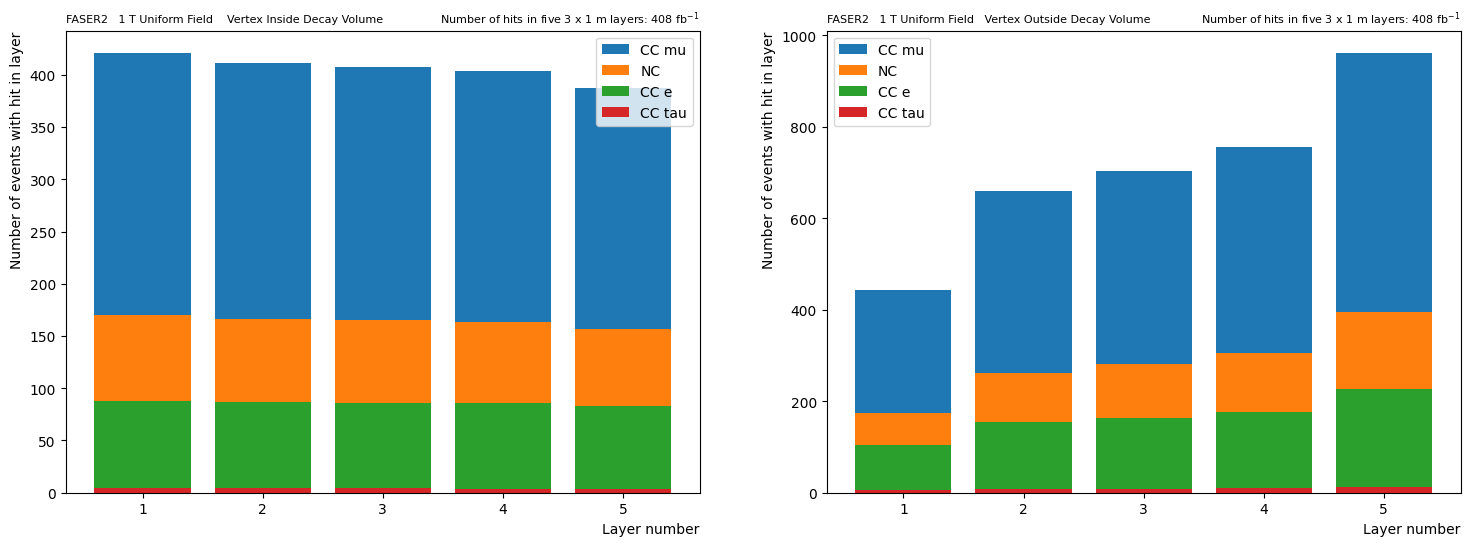

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
# for proc_name, hits in total_events_in_dv.items():
#     ax[0].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(hits))*lumi_sf, label=proc_name);
ax[0].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_in_dv['CC mu']))*lumi_sf, label='CC mu');
ax[0].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_in_dv['NC']))*lumi_sf, label='NC');
ax[0].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_in_dv['CC e']))*lumi_sf, label='CC e');
ax[0].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_in_dv['CC tau']))*lumi_sf, label='CC tau');




ax[0].set_xlabel("Layer number", loc='right')
ax[0].set_ylabel("Number of events with hit in layer", loc='top')
ax[0].set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax[0].set_title(r"FASER2   1 T Uniform Field    Vertex Inside Decay Volume", loc='left', fontsize=8)
ax[0].legend();


# for proc_name, hits in total_events_out_dv.items():
#     ax[1].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(hits))*lumi_sf, label=proc_name);

ax[1].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_out_dv['CC mu']))*lumi_sf, label='CC mu');
ax[1].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_out_dv['NC']))*lumi_sf, label='NC');
ax[1].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_out_dv['CC e']))*lumi_sf, label='CC e');
ax[1].bar(np.linspace(1, 5, 5), np.array(get_nevents_with_hit_in_layer(total_events_out_dv['CC tau']))*lumi_sf, label='CC tau');

ax[1].set_xlabel("Layer number", loc='right')
ax[1].set_ylabel("Number of events with hit in layer", loc='top')
ax[1].set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax[1].set_title(r"FASER2   1 T Uniform Field   Vertex Outside Decay Volume", loc='left', fontsize=8)
ax[1].legend();
plt.savefig("vAir-events-with-hits-in-layer-byFlavour.pdf")
plt.savefig("vAir-events-with-hits-in-layer-byFlavour.png", dpi=300)

In [16]:
print(f"Raw number of events with hits in all five layer - vertex inside decay volume:  Light = {light_nevents_in_dv_all_layers_hit:<.2f}   Charm = {charm_nevents_in_dv_all_layers_hit:<.2f}   Total = {light_nevents_in_dv_all_layers_hit + charm_nevents_in_dv_all_layers_hit:<.2f}")
print(f"Raw number of events with hits in all five layer - vertex outside decay volume: Light = {light_nevents_out_dv_all_layers_hit:<.2f}   Charm = {charm_nevents_out_dv_all_layers_hit:<.2f}   Total = {light_nevents_out_dv_all_layers_hit + charm_nevents_out_dv_all_layers_hit:<.2f}")

print(f"Raw total number of events inside decay volume : Light = {len(light_flav_hits_in_dv) }   Charm = {len(charm_flav_hits_in_dv)}    Total = {(len(light_flav_hits_in_dv) + len(charm_flav_hits_in_dv)):.2f}")
print(f"Raw total number of events outside decay volume: Light = {len(light_flav_hits_out_dv)}   Charm = { len(charm_flav_hits_out_dv)}  Total = {(len(light_flav_hits_out_dv) + len(charm_flav_hits_out_dv)):.2f}")

Raw number of events with hits in all five layer - vertex inside decay volume:  Light = 7111.00   Charm = 1473.00   Total = 8584.00
Raw number of events with hits in all five layer - vertex outside decay volume: Light = 5710.00   Charm = 1787.00   Total = 7497.00
Raw total number of events inside decay volume : Light = 7846   Charm = 1554    Total = 9400.00
Raw total number of events outside decay volume: Light = 60624   Charm = 21109  Total = 81733.00


In [11]:
light_events_in_dv_nlayers_hit = get_nevents_with_hit_in_layer(light_flav_hits_in_dv)
light_events_out_dv_nlayers_hit = get_nevents_with_hit_in_layer(light_flav_hits_out_dv)
    
charm_events_in_dv_nlayers_hit = get_nevents_with_hit_in_layer(charm_flav_hits_in_dv)
charm_events_out_dv_nlayers_hit = get_nevents_with_hit_in_layer(charm_flav_hits_out_dv)

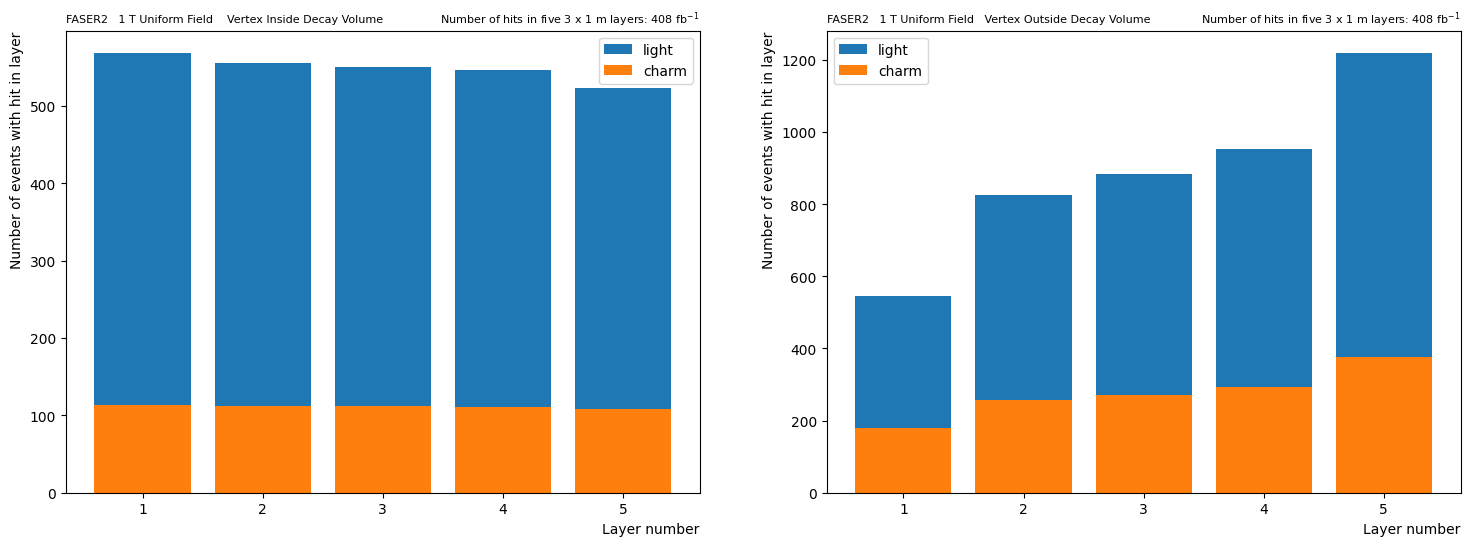

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].bar(np.linspace(1, 5, 5), np.array(light_events_in_dv_nlayers_hit)*lumi_sf, label='light');
ax[0].bar(np.linspace(1, 5, 5), np.array(charm_events_in_dv_nlayers_hit)*lumi_sf, label='charm');
ax[0].set_xlabel("Layer number", loc='right')
ax[0].set_ylabel("Number of events with hit in layer", loc='top')
ax[0].set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax[0].set_title(r"FASER2   1 T Uniform Field    Vertex Inside Decay Volume", loc='left', fontsize=8)
ax[0].legend();


ax[1].bar(np.linspace(1, 5, 5), np.array(light_events_out_dv_nlayers_hit)*lumi_sf, label='light');
ax[1].bar(np.linspace(1, 5, 5), np.array(charm_events_out_dv_nlayers_hit)*lumi_sf, label='charm');
ax[1].set_xlabel("Layer number", loc='right')
ax[1].set_ylabel("Number of events with hit in layer", loc='top')
ax[1].set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax[1].set_title(r"FASER2   1 T Uniform Field   Vertex Outside Decay Volume", loc='left', fontsize=8)
ax[1].legend();
plt.savefig("vAir-events-with-hits-in-layer.pdf")
plt.savefig("vAir-events-with-hits-in-layer.png", dpi=300)

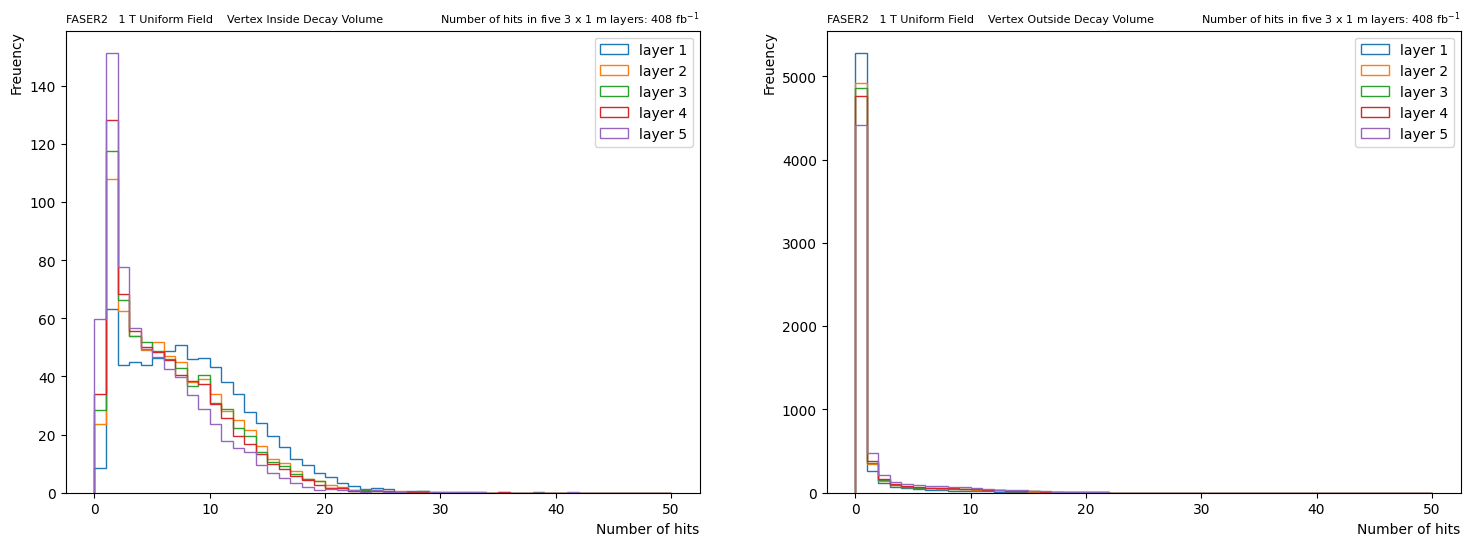

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

all_nu_in_dv = np.vstack((light_flav_hits_in_dv, charm_flav_hits_in_dv))
all_nu_out_dv = np.vstack((light_flav_hits_out_dv, charm_flav_hits_out_dv))

for i in range(0, 5):
    ax[0].hist(all_nu_in_dv[:,i], bins=np.linspace(0, 50, 51), histtype='step', label=f'layer {i+1}', weights=np.ones_like(all_nu_in_dv[:,i])*lumi_sf);
ax[0].legend();
ax[0].set_xlabel("Number of hits", loc='right')
ax[0].set_ylabel("Freuency", loc='top')
ax[0].set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax[0].set_title(r"FASER2   1 T Uniform Field    Vertex Inside Decay Volume", loc='left', fontsize=8)

for i in range(0, 5):
    ax[1].hist(all_nu_out_dv[:,i], bins=np.linspace(0, 50, 51), histtype='step', label=f'layer {i+1}', weights=np.ones_like(all_nu_out_dv[:,i])*lumi_sf);
ax[1].legend();
ax[1].set_xlabel("Number of hits", loc='right')
ax[1].set_ylabel("Freuency", loc='top')
ax[1].set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax[1].set_title(r"FASER2   1 T Uniform Field    Vertex Outside Decay Volume", loc='left', fontsize=8)

plt.savefig("vAir-num-hits-in-layers.pdf")
plt.savefig("vAir-num-hits-in-layers.png", dpi=300)

NameError: name 'light_events_nlayers_hit' is not defined

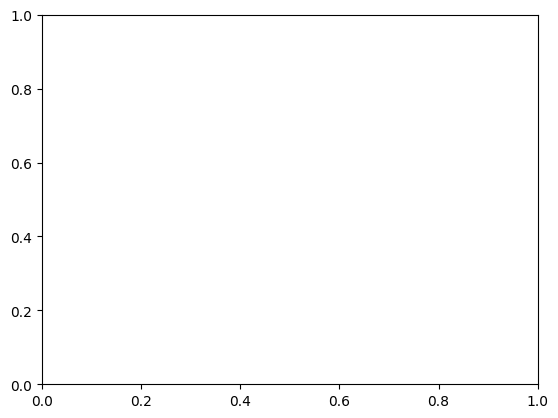

In [14]:
fig, ax = plt.subplots()
ax.bar(np.linspace(1, 5, 5), np.array(light_events_nlayers_hit)*lumi_sf, label='light');
ax.bar(np.linspace(1, 5, 5), np.array(charm_events_nlayers_hit)*lumi_sf, label='charm');
ax.set_xlabel("Layer number", loc='right')
ax.set_ylabel("Number of events with hit in layer", loc='top')
ax.set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax.set_title(r"FASER2   1 T Uniform Field", loc='left', fontsize=8)
ax.legend();

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.linspace(1, 5, 5), np.sum(light_flav_hits_in_layers, axis=0)/100, label='light');
ax.bar(np.linspace(1, 5, 5), np.sum(charm_flav_hits_in_layers, axis=0)/100, label='charm');
ax.set_xlabel("Layer number", loc='right')
ax.set_ylabel("Number of hits in layer", loc='top')
ax.set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax.set_title(r"FASER2   1 T Uniform Field", loc='left', fontsize=8)
ax.legend();

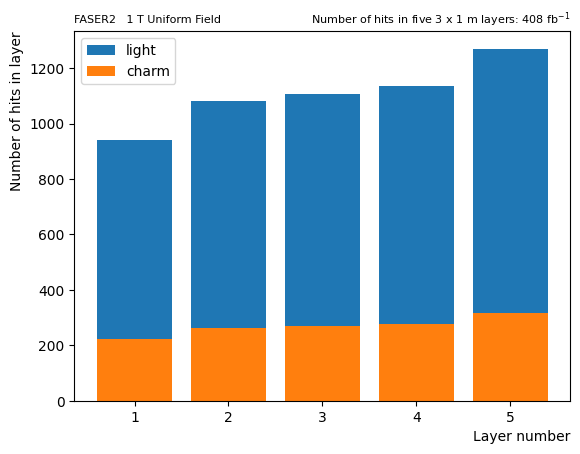

In [59]:
fig, ax = plt.subplots()
ax.bar(np.linspace(1, 5, 5), np.sum(light_flav_hits_in_layers, axis=0)/100, label='light');
ax.bar(np.linspace(1, 5, 5), np.sum(charm_flav_hits_in_layers, axis=0)/100, label='charm');
ax.set_xlabel("Layer number", loc='right')
ax.set_ylabel("Number of hits in layer", loc='top')
ax.set_title(r"Number of hits in five 3 x 1 m layers: 408 $\text{fb}^{-1}$", loc='right', fontsize=8)
ax.set_title(r"FASER2   1 T Uniform Field", loc='left', fontsize=8)
ax.legend();